<a href="https://colab.research.google.com/github/arjangvt/CodeFolio/blob/main/ML/TimeSeries/TimeSeries_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here I created a simple AR Time Series model.In the next step the "Rolling Forcast Origin technique is used.<br>
By using RFO the the AR model significantly improved.<br>
The Dataset can be found in my github repo. <br>

<br><br>
---

Written by: Arjang Fahim
Date: 12/18/2021
Last update: 5/8/2022

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time

from google.colab import drive

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
icecream_data = "YourDrive/data/ice_cream.csv"

# Ice Cream Production Data


In [ ]:
def parser(s):
  return datetime.strptime(s, '%Y-%m-%d')

In [ ]:
production_ice_cream = pd.read_csv(icecream_data, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [ ]:
production_ice_cream.rename('production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [ ]:
# infer the frequency of the data
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [ ]:
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

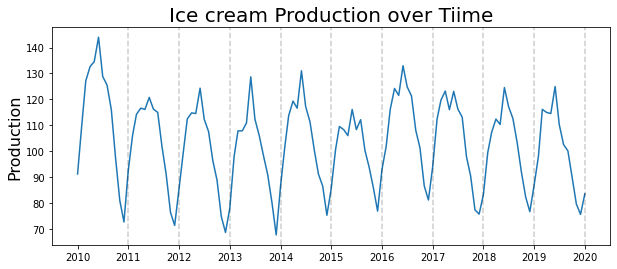

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title("Ice cream Production over Tiime", fontsize=20)
plt.ylabel("Production", fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# PACF = Partial Auto Correlation Function

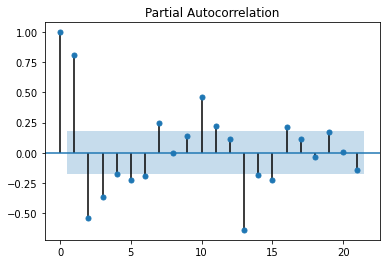

In [ ]:
pacf_plot = plot_pacf(production_ice_cream)
# Based on PACF, we should start with Auto Regressive model with lags 1, 2,3

# Get training and testing sets

In [ ]:
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

# Fit the AR Model

In [ ]:
# There two parameters needs to be passed to order AR and MA. This demo is just
# for AR model so AR=3 and MA=0
# I just decided to use lagg 3 from PACF

# create the model
model = ARMA(train_data, order=(3,0))

In [ ]:
# fit the mode
start = time()
model_fit = model.fit()
end = time()

print('Model fitting time:', end - start)

Model fitting time: 0.20613312721252441


In [ ]:
print(model_fit.summary())


                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                   84
Model:                     ARMA(3, 0)   Log Likelihood                -294.008
Method:                       css-mle   S.D. of innovations              7.903
Date:                Tue, 31 May 2022   AIC                            598.015
Time:                        03:17:28   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5080      2.176     47.575      0.000      99.244     107.772
ar.L1.production     1.0488      0.099     10.573      0.000       0.854       1.243
ar.L2.production    -0.0532 

In [ ]:
# get prediction start and end
pred_start_date =  test_data.index[0]
pred_end_date = test_data.index[-1]

In [ ]:
# get the prediction and residual
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals =  test_data - predictions

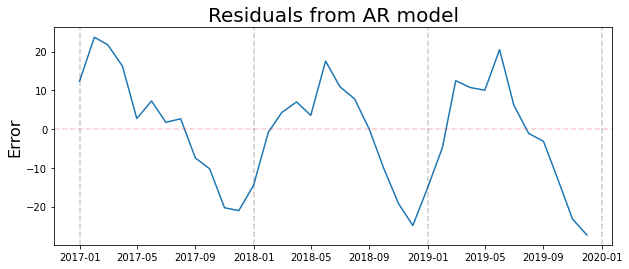

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
#plt.plot(test_data)
#plt.plot(predictions)
plt.title("Residuals from AR model", fontsize=20)
plt.ylabel("Error", fontsize=16)
plt.axhline(0,color='r', linestyle='--', alpha=0.2)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# When data follows some type of dynamic (similarity), there is information
# should be sent

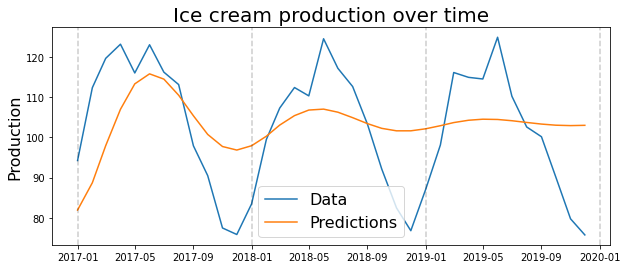

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title("Ice cream production over time", fontsize=20)
plt.ylabel("Production", fontsize=16)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)


In [ ]:
# On average what percent  we are away from our target. 
# The reseult (9%) not great and also not too bad!
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.1211


In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 13.889854998814041


In a machine learning modeling generally if we break our data in 30% for testing and 70% training, in the training as we go far in time the model tend to
flatten more and more. So in time series (related to the context) we use "Rolling Forcast Origin"

# Rolling Forcast Origin
## Idea Predict one month in advance each time

### Train on months 1,2,..., k-3 -> predict month k - 2 <br>
### Train on months 1,2,..., k-3, k-2 -> predict month k - 1<br>
### Train on months 1,2,..., k-3, k-2, k-1 -> predict month k <br>

... 

### Average all predictions


In [ ]:
# create the model
predictions_rolling = pd.Series()

for end_date in test_data.index:
  train_data = production_ice_cream[:end_date - timedelta(days=1)]
  model = ARMA(train_data, order=(3,0))
  model_fit = model.fit()
  pred = model_fit.predict(end_date)
  predictions_rolling.loc[end_date] = pred.loc[end_date]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
residuals_rolling = test_data - predictions_rolling

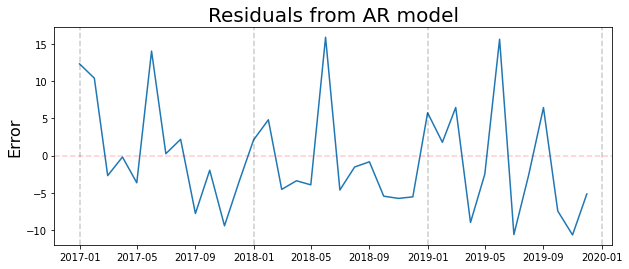

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title("Residuals from AR model", fontsize=20)
plt.ylabel("Error", fontsize=16)
plt.axhline(0,color='r', linestyle='--', alpha=0.2)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

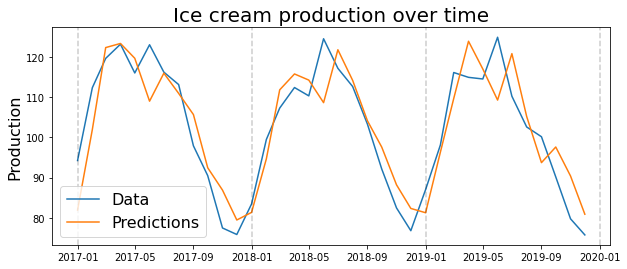

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions_rolling)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title("Ice cream production over time", fontsize=20)
plt.ylabel("Production", fontsize=16)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
